In [1]:
import numpy as np
import pandas as pd
import os
import mne
import matplotlib.pyplot as plt

%matplotlib qt

# ARI

In [2]:
def deduplicate_responses(trial):
    """Remove duplicate 3 and 4 triggers (button presses), keep first occurrence."""
    clean_array = []
    seen = set()
    duplicates = []


    for row in trial:
        code = row[2]
        if code in (3, 4):
            if code in seen:
                duplicates.append(row)
                continue
            seen.add(code)
        clean_array.append(row)

    return np.array(clean_array), np.array(duplicates) if duplicates else None

In [3]:
def classify_trial(trial):
    """Classify a trial as 'go', 'stop', or 'bad' based on event codes."""
    # Extract event codes
    codes = trial[:, 2].tolist()

    # Must start and end correctly
    if codes[0] != 1 or codes[-1] != 6:
        return 'bad'

    # Required onset
    if 2 not in codes:
        return 'bad'

    # Enforce order: 1 < 2 < 6
    i1 = codes.index(1)
    i2 = codes.index(2)
    i6 = len(codes) - 1
    if not (i1 < i2 < i6):
        return 'bad'

    has_stop = 5 in codes
    has_3 = 3 in codes
    has_4 = 4 in codes

    # Count occurrences
    n3 = codes.count(3)
    n4 = codes.count(4)
    n5 = codes.count(5)

    # ---------- GO TRIAL ----------
    # 1 - 2 - 3 & 4 (any order) - 6
    if not has_stop:
        if has_3 and has_4 and n3 == 1 and n4 == 1:
            return 'go'
        else:
            return 'bad'

    # ---------- STOP TRIAL ----------
    # 1 - 2 - 5 - 6 (no responses)
    if has_stop:
        if n5 == 1 and not has_3 and not has_4:
            return 'stop'
        else:
            return 'bad'


In [4]:
eeg_path = "C:\\Users\\a1902989\\Box\\Katya\\# PD project\\pilot\\eeg"
eeg_file_name = "PDc_s1_sub00_GR_ARI.vhdr"
raw = mne.io.read_raw_brainvision(os.path.join(eeg_path, eeg_file_name), preload=True)
raw.info

Extracting parameters from C:\Users\a1902989\Box\Katya\# PD project\pilot\eeg\PDc_s1_sub00_GR_ARI.vhdr...
Setting channel info structure...
Reading 0 ... 818539  =      0.000 ...  1637.078 secs...


C:\Users\a1902989\AppData\Local\Temp\ipykernel_32148\3301080942.py:3: RuntimeWarning: No coordinate information found for channels ['Photodiode', 'Acc X', 'Acc Y', 'Acc Z', 'EMG']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(os.path.join(eeg_path, eeg_file_name), preload=True)
C:\Users\a1902989\AppData\Local\Temp\ipykernel_32148\3301080942.py:3: RuntimeWarning: Not setting positions of 5 misc channels found in montage:
['Photodiode', 'Acc X', 'Acc Y', 'Acc Z', 'EMG']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_brainvision(os.path.join(eeg_path, eeg_file_name), preload=True)


<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, Fz, F3, F7, FT9, FC5, FC1, C3, T7, TP9, CP5, CP1, Pz, P3, ...
 chs: 64 EEG, 5 misc
 custom_ref_applied: False
 dig: 67 items (3 Cardinal, 64 EEG)
 highpass: 0.0 Hz
 lowpass: 131.0 Hz
 meas_date: 2026-01-27 11:25:58 UTC
 nchan: 69
 projs: []
 sfreq: 500.0 Hz
>

**Prep for epoching: Read events and annotate bad trials**

In [5]:
# 1 = trial start (empty bars appear)
# 2 = trial onset (bar starts filling)
# 3 = left response
# 4 = right response
# 5 = stop signal presentation
# 6 = trial end (prior to ITI)

# 19 = go only practice
# 20 = go/stop practice
# 21:n trials+20 = training blocks

events_dict = mne.events_from_annotations(raw)[1]
events = mne.events_from_annotations(raw)[0]
task_onset = np.where(events[:, 2] == 21)[0][0]   # index of the first block onset
events = events[task_onset:].copy() # drop practice trials
events_dict

Used Annotations descriptions: [np.str_('Comment/SyncOff'), np.str_('Comment/SyncOn'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6'), np.str_('Stimulus/S 19'), np.str_('Stimulus/S 20'), np.str_('Stimulus/S 21'), np.str_('Stimulus/S 22'), np.str_('Stimulus/S 23'), np.str_('Stimulus/S 24'), np.str_('Stimulus/S 25'), np.str_('Stimulus/S 26'), np.str_('Stimulus/S 27'), np.str_('Stimulus/S 28'), np.str_('Stimulus/S 29'), np.str_('Stimulus/S 30'), np.str_('Stimulus/S 31'), np.str_('Stimulus/S 32')]
Used Annotations descriptions: [np.str_('Comment/SyncOff'), np.str_('Comment/SyncOn'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6'), np.str_('Stimulus/S 19'), np.str_('Stimulus/S 20'), np.str_('Stimulus/S 21'), np.str_('Stimulus/S 22'), np.str_('Stimulus/S 23'), np.str_('Stimulus/S 

{np.str_('Comment/SyncOff'): 10001,
 np.str_('Comment/SyncOn'): 10002,
 np.str_('Stimulus/S  1'): 1,
 np.str_('Stimulus/S  2'): 2,
 np.str_('Stimulus/S  3'): 3,
 np.str_('Stimulus/S  4'): 4,
 np.str_('Stimulus/S  5'): 5,
 np.str_('Stimulus/S  6'): 6,
 np.str_('Stimulus/S 19'): 19,
 np.str_('Stimulus/S 20'): 20,
 np.str_('Stimulus/S 21'): 21,
 np.str_('Stimulus/S 22'): 22,
 np.str_('Stimulus/S 23'): 23,
 np.str_('Stimulus/S 24'): 24,
 np.str_('Stimulus/S 25'): 25,
 np.str_('Stimulus/S 26'): 26,
 np.str_('Stimulus/S 27'): 27,
 np.str_('Stimulus/S 28'): 28,
 np.str_('Stimulus/S 29'): 29,
 np.str_('Stimulus/S 30'): 30,
 np.str_('Stimulus/S 31'): 31,
 np.str_('Stimulus/S 32'): 32}

In [ ]:
events = events[~np.isin(events[:, 2], [10001, 10002])]  # remove extraneous triggers

starts = np.where(events[:, 2] == 1)[0]
ends   = np.where(events[:, 2] == 6)[0]

assert len(starts) == len(ends), "Unmatched trial start/end triggers"

trial_events = []

for s, e in zip(starts, ends):
    trial_events.append(events[s:e+1])

In [8]:
np.where(events[:, 2] == 10001)[0]

array([  65,  133,  179,  828, 1300, 1480])

In [10]:
trial_events

[array([[102980,      0,      1],
        [103281,      0,      2],
        [103688,      0,      3],
        [103697,      0,      4],
        [103938,      0,      6]]),
 array([[104706,      0,      1],
        [105063,      0,      2],
        [105465,      0,      3],
        [105473,      0,      4],
        [105715,      0,      6]]),
 array([[106482,      0,      1],
        [106865,      0,      2],
        [107274,      0,      3],
        [107283,      0,      4],
        [107516,      0,      6]]),
 array([[108283,      0,      1],
        [108696,      0,      2],
        [109101,      0,      3],
        [109117,      0,      4],
        [109351,      0,      6]]),
 array([[110118,      0,      1],
        [110386,      0,      2],
        [110785,      0,      3],
        [110802,      0,      4],
        [111044,      0,      6]]),
 array([[111811,      0,      1],
        [112269,      0,      2],
        [112653,      0,      3],
        [112920,      0,      6]]),
 a

In [19]:
# Deduplicate key responses and classify trials
clean_trials = [deduplicate_responses(t)[0] for t in trial_events]
duplicates = [deduplicate_responses(t)[1] for t in trial_events if deduplicate_responses(t)[1] is not None]
events_clean = events.copy()

for dup in duplicates:
    events_clean = events_clean[~np.all(events_clean == dup, axis=1)]

labels = [classify_trial(t) for t in clean_trials]

good_go   = [t for t, l in zip(clean_trials, labels) if l == 'go']
good_stop = [t for t, l in zip(clean_trials, labels) if l == 'stop']
bad       = [t for t, l in zip(clean_trials, labels) if l == 'bad']

print(f"Go trials   : {len(good_go)}")
print(f"Stop trials : {len(good_stop)}")
print(f"Bad trials  : {len(bad)}")

Go trials   : 181
Stop trials : 36
Bad trials  : 167


In [20]:
# Setting up annotations for bad trials: based on behavioral performance
sfreq = raw.info['sfreq']

onsets = []
durations = []
descriptions = []

for trial in bad:
    start_samp = trial[0, 0]
    end_samp   = trial[-1, 0]

    onsets.append(start_samp / sfreq)
    durations.append((end_samp - start_samp) / sfreq)
    descriptions.append('BAD')
bad_annots = mne.Annotations(onsets, durations, descriptions)

# Remove existing annotations (events are stored as np.array) and set new ones
raw.set_annotations(None)
raw.set_annotations(bad_annots)
# raw.plot(events=events_clean)


<RawBrainVision | PDc_s1_sub00_GR_ARI.eeg, 69 x 818540 (1637.1 s), ~431.0 MiB, data loaded>

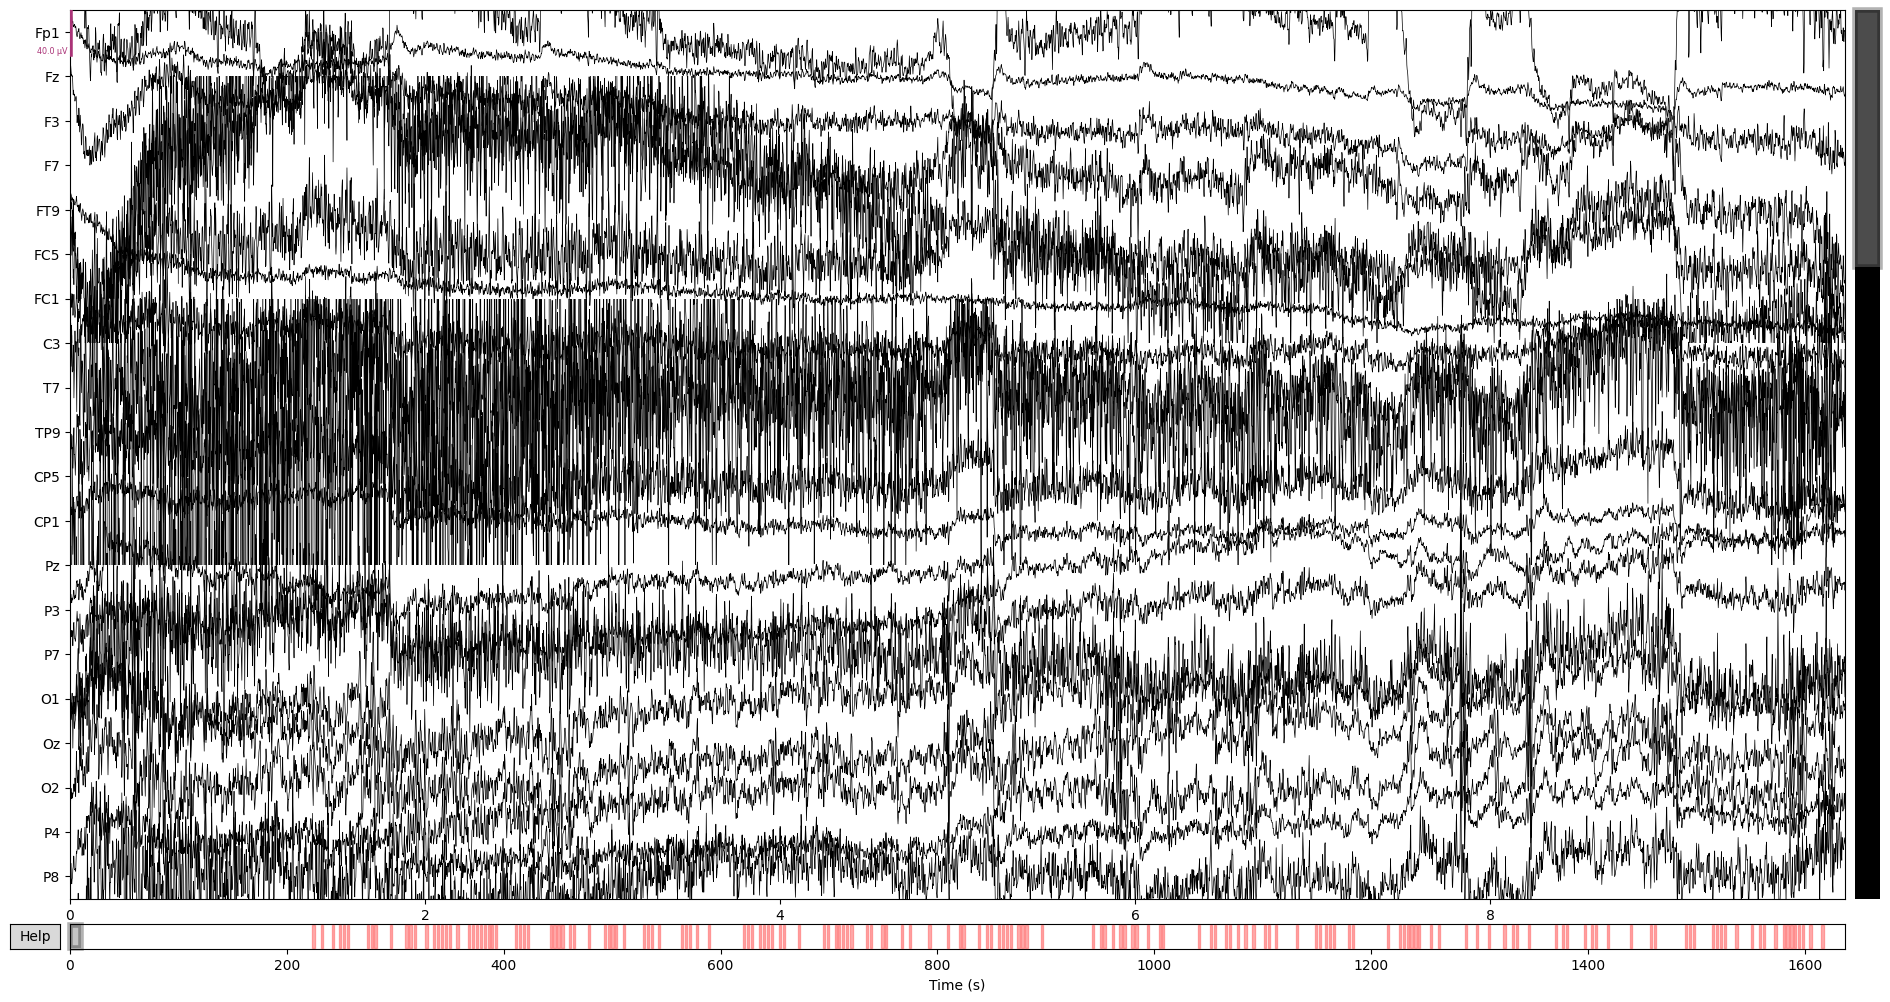

In [21]:
raw.plot(events=events_clean)

**Define timing and events for epoching**

In [22]:
# Timing between start of the trial and onset of bars AND start to end of trial
sfreq = raw.info['sfreq']

starts = events[events[:, 2] == 1][:, 0]
onsets = events[events[:, 2] == 2][:, 0]
ends = events[events[:, 2] == 6][:, 0]

n_trials = len(starts)

timing = pd.DataFrame({
    'start_to_onset': (onsets - starts) / sfreq,
    'start_to_end': (ends - starts) / sfreq
})
timing.describe()

,start_to_onset,start_to_end
count,384.000000,384.000000
mean,0.750615,2.058536
std,0.135388,0.135130
min,0.500000,1.818000
25%,0.636000,1.950000
50%,0.755000,2.068000
75%,0.864500,2.170000
max,1.004000,2.302000


In [23]:
# Timing of inter-trial intervals (ITI)
intervals = np.append(np.where((starts[1:] - ends[:-1]) / sfreq <= 2,
                                (starts[1:] - ends[:-1]) / sfreq,
                                np.nan),
                      np.nan)
pd.Series(intervals).describe()


count    372.000000
mean       1.534210
std        0.001671
min        1.510000
25%        1.534000
50%        1.534000
75%        1.534000
max        1.538000
dtype: float64

In [24]:
# Timing from stop signal to end of trial
rows = []

for trial in good_stop:
    codes = trial[:, 2]
    samp_1 = trial[codes == 1][0, 0]
    samp_2 = trial[codes == 2][0, 0]
    samp_5 = trial[codes == 5][0, 0]
    samp_6 = trial[codes == 6][0, 0]

    rows.append({
        'start_to_onset': (samp_2 - samp_1) / sfreq,
        'onset_to_stop': (samp_5 - samp_2) / sfreq,
        'stop_to_end': (samp_6 - samp_5) / sfreq,
    })

stop_timing = pd.DataFrame(rows)
stop_timing.describe()

,start_to_onset,onset_to_stop,stop_to_end
count,36.000000,36.000000,36.000000
mean,0.764167,0.591389,0.717611
std,0.152219,0.023136,0.022972
min,0.520000,0.552000,0.650000
25%,0.621000,0.579500,0.700000
50%,0.768000,0.586000,0.718000
75%,0.905000,0.602500,0.734000
max,0.974000,0.662000,0.752000


Minimum timing for STOP epochs:
- 1 sec prior to STOP signal:
    - start to bar onset: 0.51 s
    - bar onset to stop: 0.48 s
- 2.1 sec from stop signal to the next trial:
    - stop to end: 0.59 s
    - iti (end to start of the next trial): 1.51 s

**Conclusion:
Epoch around STOP signal: [-0.9 1.5]**

In [25]:
# Timing from key press to end of trial
rows = []

for trial in good_go:
    codes = trial[:, 2]
    samp_1 = trial[codes == 1][0, 0]
    samp_2 = trial[codes == 2][0, 0]
    samp_3 = trial[codes == 3][0, 0]
    samp_4 = trial[codes == 4][0, 0]
    samp_6 = trial[codes == 6][0, 0]

    rows.append({
        'start_to_onset': (samp_2 - samp_1) / sfreq,
        'onset_to_key1': (samp_3 - samp_2) / sfreq,
        'onset_to_key2': (samp_4 - samp_2) / sfreq,
        'key1_to_end': (samp_6 - samp_3) / sfreq,
        'key2_to_end': (samp_6 - samp_4) / sfreq,
    })

stop_timing = pd.DataFrame(rows)
stop_timing.describe()

,start_to_onset,onset_to_key1,onset_to_key2,key1_to_end,key2_to_end
count,181.000000,181.000000,181.000000,181.000000,181.000000
mean,0.746376,0.815569,0.823735,0.492530,0.484365
std,0.130377,0.027721,0.028429,0.028307,0.028570
min,0.506000,0.752000,0.758000,0.400000,0.384000
25%,0.638000,0.798000,0.804000,0.482000,0.466000
50%,0.748000,0.814000,0.822000,0.498000,0.484000
75%,0.860000,0.832000,0.844000,0.516000,0.500000
max,1.004000,0.910000,0.924000,0.552000,0.554000


Minimum timing for GO epochs:
- 1.24 sec prior to key press:
    - start to bar onset: 0.5 s
    - bar onset to key press: 0.74 s
- **1.84 sec** from key press to the next trial:
    - key press to end: 0.33 s
    - iti (end to start of the next trial): 1.51 s

**Conclusion:
Epoch around STOP signal: [-1 1.5]** -> **NEED TO INCREASE FEEDBACK TIME!!!!!!!!**

_______________

Not setting metadata
96 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 96 events and 1201 original time points ...
60 bad epochs dropped


C:\Users\a1902989\AppData\Local\Temp\ipykernel_39164\193695298.py:17: RuntimeWarning: More events than default colors available. You should pass a list of unique colors.
  epochs_stop.plot(events=events_clean) # NOTE: duplication of 2 trigger in some epochs on the plot (the data is fine)


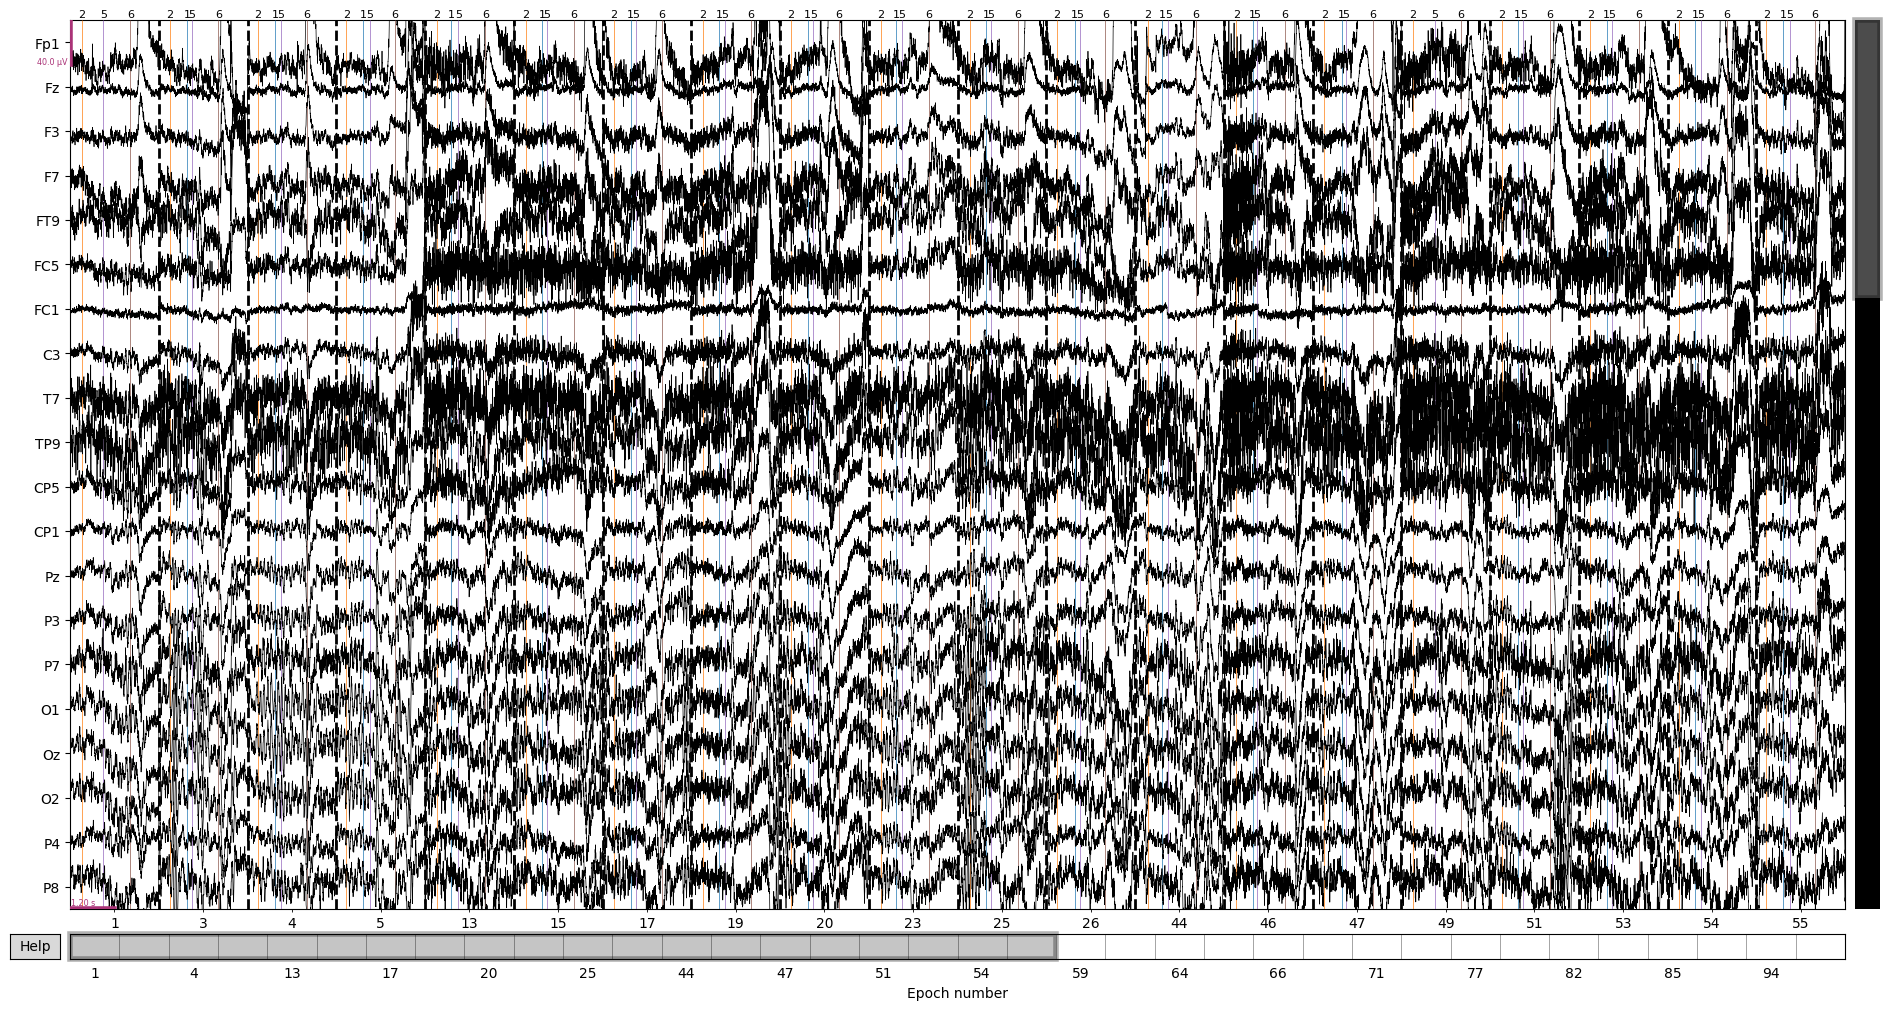

In [26]:
# EPOCHING: STOP trials
events_stop = events_clean[events_clean[:, 2] == 5]

event_id_stop = {'Stimulus/S  5': 5}
epo_tmin_stop, epo_tmax_stop = -0.9, 1.5

epochs_stop = mne.Epochs(
    raw,
    events_stop,
    event_id=event_id_stop,
    tmin=epo_tmin_stop,
    tmax=epo_tmax_stop,
    baseline=(epo_tmin_stop, 0),
    reject_by_annotation=True,
    preload=True,
)
epochs_stop.plot(events=events_clean) # NOTE: duplication of 2 trigger in some epochs on the plot (the data is fine)


*CHECK THE 2 TRIGGERS IN GO TRIALS!!!*

Not setting metadata
181 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 181 events and 1151 original time points ...
0 bad epochs dropped


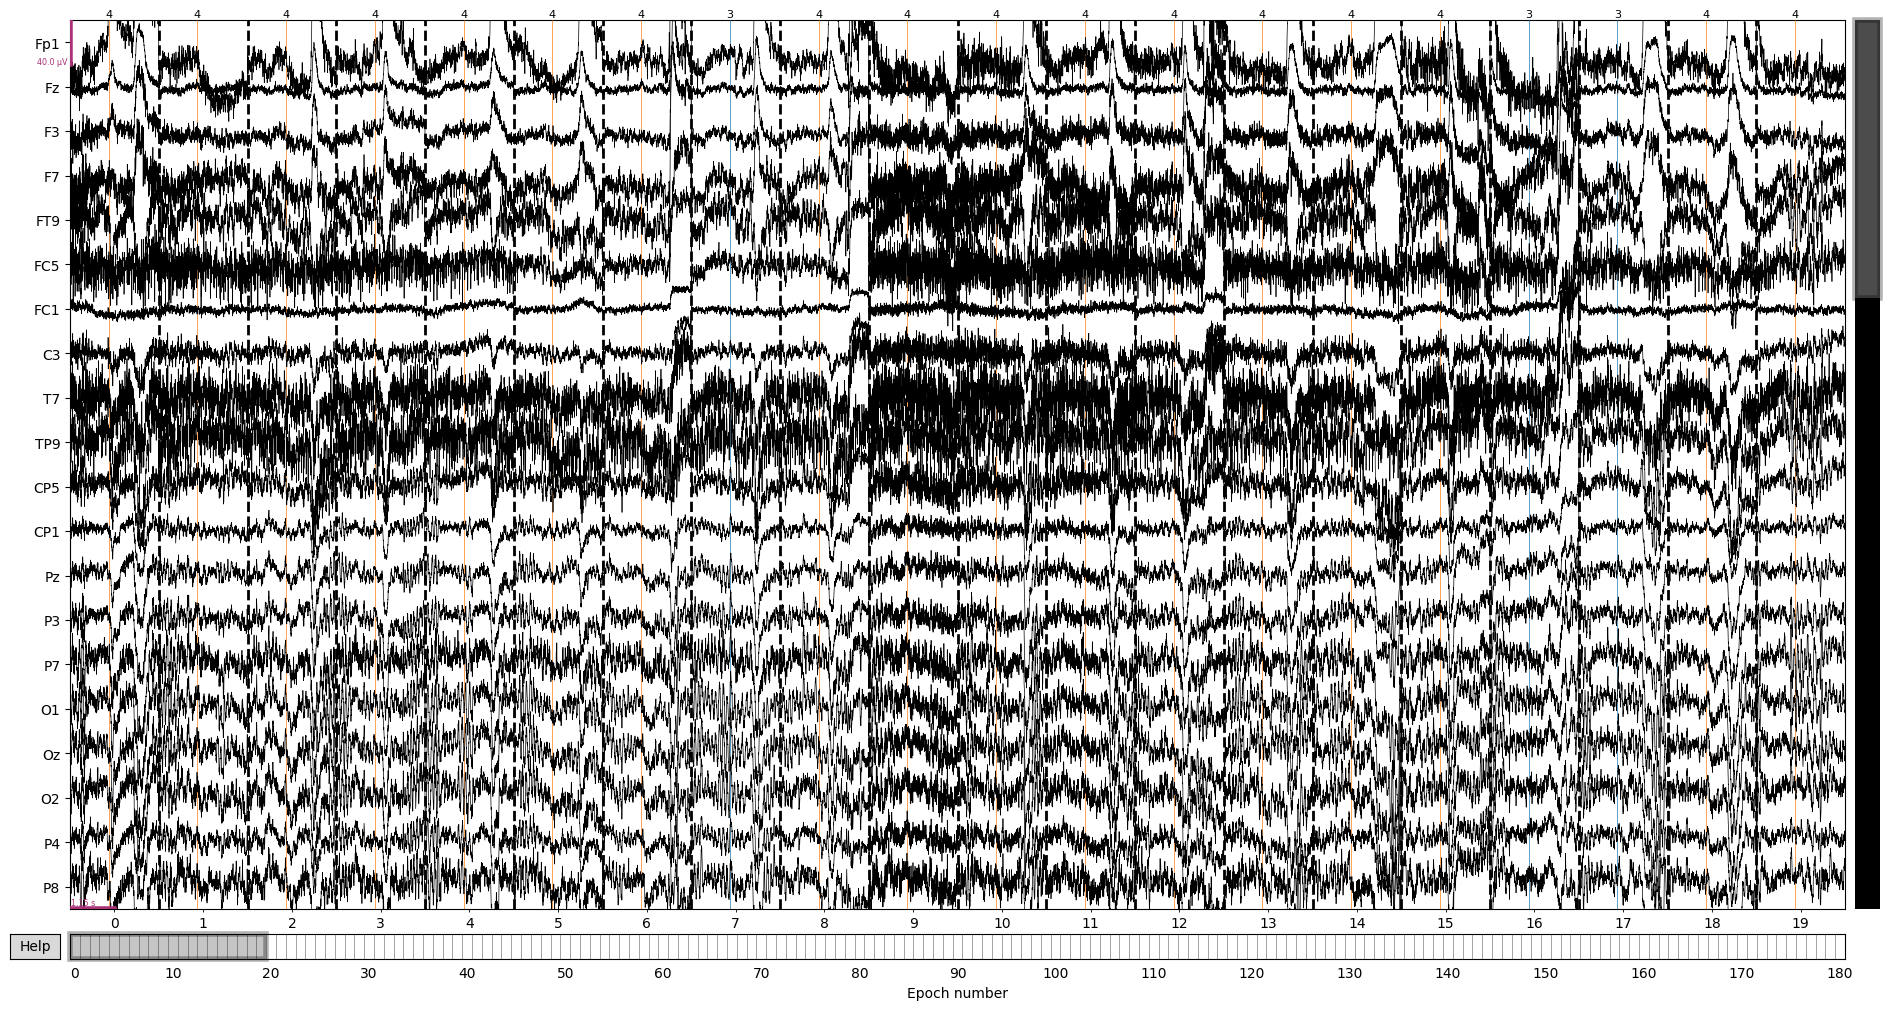

In [27]:
# EPOCHING: GO trials (last response)
events_go_last = []

for trial in good_go:
    # select rows where code is 3 or 4
    resp_rows = trial[np.isin(trial[:, 2], [3, 4])]

    # pick the one with the largest sample index (last response)
    last_resp = resp_rows[np.argmax(resp_rows[:, 0])]

    events_go_last.append(last_resp)

events_go_last = np.array(events_go_last)

epochs_go = mne.Epochs(
    raw,
    events_go_last,
    event_id={'go_last_resp_3': 3, 'go_last_resp_4': 4},
    tmin=-1,
    tmax=1.3,
    baseline=(-1, 0),
    preload=True,
)

epochs_go.plot(events=events_go_last) # NOTE: duplication of 2 trigger in some epochs on the plot (the data is fine)


In [29]:
epo_save_path = "D:\\BonoKat\\research project\\# PD project\\data_analysis\\ARI\\epochs"
np.save(os.path.join(epo_save_path, f'{eeg_file_name[:-5]}_clean_events.npy'), events_clean)
epochs_stop.save(os.path.join(epo_save_path, f'{eeg_file_name[:-5]}_STOP_epochs.fif'), overwrite=True)
epochs_go.save(os.path.join(epo_save_path, f'{eeg_file_name[:-5]}_GO_epochs.fif'), overwrite=True)

Overwriting existing file.
Overwriting existing file.
Overwriting existing file.


C:\Users\a1902989\AppData\Local\Temp\ipykernel_39164\2579800246.py:3: RuntimeWarning: This filename (D:\BonoKat\research project\# PD project\data_analysis\ARI\epochs\PDc_s1_sub00_GR_ARI_STOP_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_stop.save(os.path.join(epo_save_path, f'{eeg_file_name[:-5]}_STOP_epochs.fif'), overwrite=True)
C:\Users\a1902989\AppData\Local\Temp\ipykernel_39164\2579800246.py:4: RuntimeWarning: This filename (D:\BonoKat\research project\# PD project\data_analysis\ARI\epochs\PDc_s1_sub00_GR_ARI_GO_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_go.save(os.path.join(epo_save_path, f'{eeg_file_name[:-5]}_GO_epochs.fif'), overwrite=True)


[WindowsPath('D:/BonoKat/research project/# PD project/data_analysis/ARI/epochs/PDc_s1_sub00_GR_ARI_GO_epochs.fif')]